
# iCNT Testbed — Dual-Channel Validation (φ vs ψ)

This notebook gives you **the most informative single-pass test** of Inverted CNT (iCNT) inside JupyterLab:

1. **Baseline vs. Inversion**: Kuramoto-like network, compute **φ (resonance)** and **ψ (dissonance)**.  
2. **Causal Probes**: Activate Anti-Anchor / Anti-Echo / Anti-Benediction at different times and magnitudes; measure **Δ fracture**.  
3. **Parameter Sweep (Heatmaps)**: Map **time-to-fracture**, **final φ**, and **ψ>φ area** over intensity × timing.  
4. **Statistical Test (Permutation)**: Quantify significance of inversion effects across random seeds (Cohen’s *d*, permutation *p*).  
5. **Phase-Specific Sensitivity**: Impulse-response curves: *when* an anti-glyph hits matters as much as *how strongly*.  

> Metrics:  
> - φ(t): order parameter (0..1).  
> - ψ(t): normalized phase dispersion + anti-glyph penalties (0..1).  
> - **Fracture**: first time with ψ(t) > φ(t).  


In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, json
from pathlib import Path

# Save dir
OUT = Path("./iCNT_outputs")
OUT.mkdir(exist_ok=True)

rng = np.random.default_rng(7)

def order_parameter(phases):
    z = np.exp(1j * phases).mean()
    return np.abs(z)

def pairwise_phase_diff(phases):
    diffs = np.abs(np.subtract.outer(phases, phases))
    diffs = np.minimum(diffs, 2*np.pi - diffs)
    mean_diff = diffs[np.triu_indices_from(diffs, k=1)].mean()
    return mean_diff / np.pi  # normalize [0,1]

def simulate_icnt(
    N=16, T=300, dt=0.05, K_base=1.1, noise_sigma=0.03, seed=None,
    t_anchor=80, t_echo=150, t_bened=220,
    level_anchor=0.7, level_echo=0.6, level_bened=1.0
):
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)

    subset_anchor = np.arange(0, N, 4)
    subset_echo   = np.arange(1, N, 4)
    subset_bened  = np.arange(2, N, 4)

    phi, psi = [], []
    t_fracture = None

    for t in range(T):
        K = np.full((N, N), K_base / N)
        np.fill_diagonal(K, 0.0)

        # Anti-glyph activations
        aa = 0.0; ae = 0.0; ab = 0.0
        if t >= t_anchor:
            aa = level_anchor
            for i in subset_anchor:
                K[i, :] *= -aa
        if t >= t_echo:
            ae = level_echo
            for i in subset_echo:
                K[i, :] *= (1.0 - ae)
        ab_active = False
        if t >= t_bened:
            ab = level_bened
            ab_active = True

        # Kuramoto-like update
        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * np.sin(-theta_diff)).sum(axis=1)

        noise = rng.normal(0.0, noise_sigma, size=N)
        if ab_active:
            idx = subset_bened
            noise[idx] += rng.standard_t(df=2, size=len(idx)) * 0.08 * ab

        theta = (theta + (omega + sync_term) * dt + noise * math.sqrt(dt)) % (2*np.pi)

        r = order_parameter(theta)
        dis = pairwise_phase_diff(theta)

        penalty = 0.15*(aa + ae) + 0.25*(ab>0)
        ps = min(1.0, dis + penalty)

        phi.append(r); psi.append(ps)
        if t_fracture is None and ps > r:
            t_fracture = t

    return np.array(phi), np.array(psi), t_fracture



## 1) Baseline vs Inversion (single run)


First fracture @ t = 0


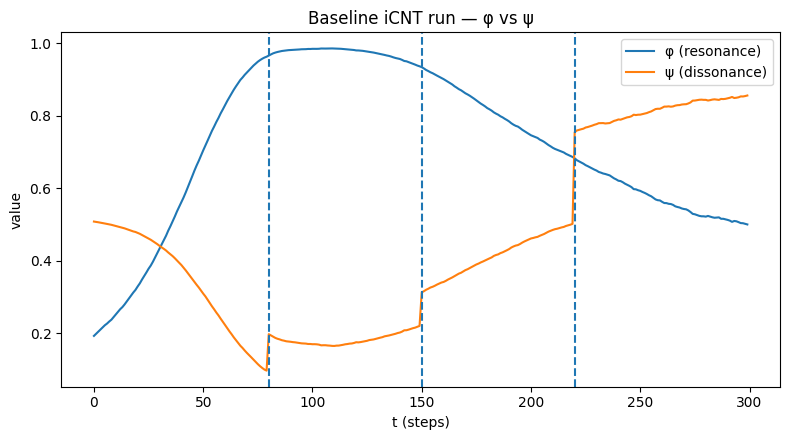

In [2]:

phi, psi, tF = simulate_icnt(seed=42)
print("First fracture @ t =", tF)

plt.figure(figsize=(8,4.5))
plt.plot(phi, label='φ (resonance)')
plt.plot(psi, label='ψ (dissonance)')
plt.axvline(80, linestyle='--'); plt.axvline(150, linestyle='--'); plt.axvline(220, linestyle='--')
plt.xlabel("t (steps)"); plt.ylabel("value")
plt.title("Baseline iCNT run — φ vs ψ")
plt.legend()
plt.tight_layout(); plt.savefig(OUT/"baseline_phi_psi.png", dpi=200); plt.show()



## 2) Parameter Sweep — Heatmaps

We sweep **Anti-Anchor level** × **activation time**, and read three outcome maps:

- **Time-to-Fracture** (earlier is darker)  
- **Final φ** (lower implies more disruption)  
- **Area(ψ>φ)** (how long the system lived in fracture)


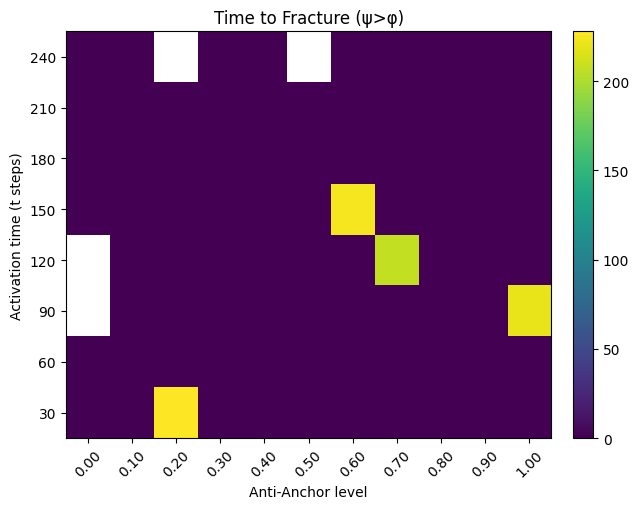

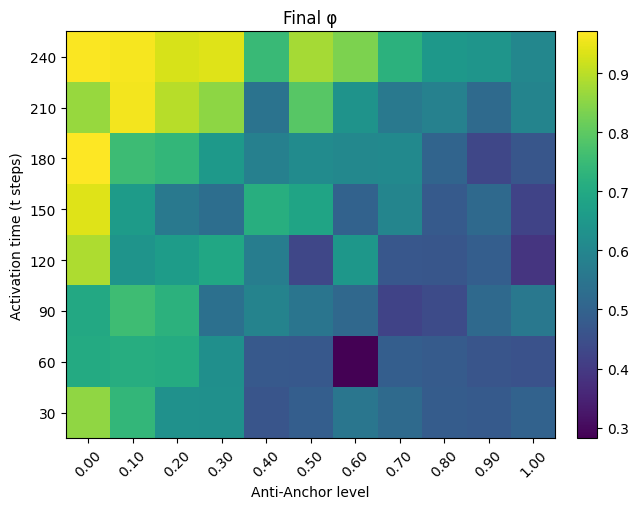

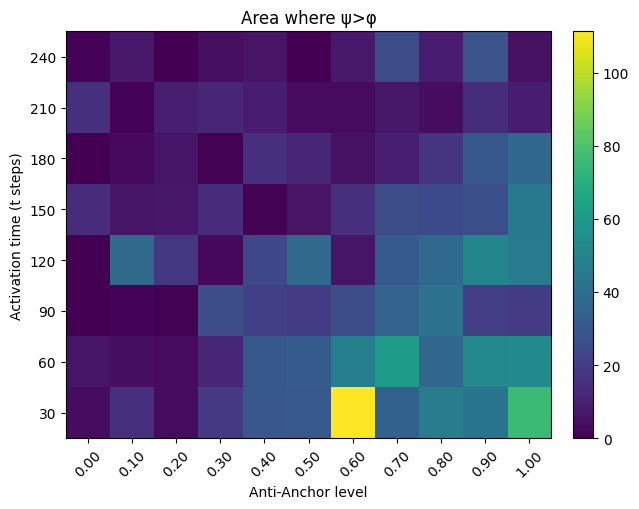

In [3]:

import numpy as np, matplotlib.pyplot as plt

levels = np.linspace(0.0, 1.0, 11)       # Anti-Anchor intensity
times  = np.arange(30, 241, 30)          # activation time

TTF = np.full((len(times), len(levels)), np.nan, dtype=float)   # time-to-fracture
Fphi = np.full_like(TTF, np.nan)                                 # final φ
Apsi = np.full_like(TTF, np.nan)                                 # area where ψ>φ

for i, tA in enumerate(times):
    for j, lev in enumerate(levels):
        phi, psi, tF = simulate_icnt(t_anchor=int(tA), level_anchor=float(lev), seed=100+i*13+j*3)
        TTF[i,j] = tF if tF is not None else np.nan
        Fphi[i,j] = phi[-1]
        # FIXED: sum first, then (optionally) cast
        Apsi[i,j] = np.maximum(0, psi - phi).sum()

def heat(m, title, xticks, yticks, fname):
    plt.figure(figsize=(6.5,5.2))
    im = plt.imshow(m, aspect='auto', origin='lower')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(xticks)), [f"{x:.2f}" for x in xticks], rotation=45)
    plt.yticks(range(len(yticks)), yticks)
    plt.xlabel("Anti-Anchor level")
    plt.ylabel("Activation time (t steps)")
    plt.title(title)
    plt.tight_layout(); plt.savefig(OUT/fname, dpi=220); plt.show()

heat(TTF, "Time to Fracture (ψ>φ)", levels, times, "heat_ttf.png")
heat(Fphi, "Final φ", levels, times, "heat_final_phi.png")
heat(Apsi, "Area where ψ>φ", levels, times, "heat_area_psigreaterphi.png")




## 3) Causal Probe — Impulse Response vs. Timing

For a fixed intensity, we slide the activation time and measure **Δφ**, **Δψ**, and **fracture probability** across seeds.


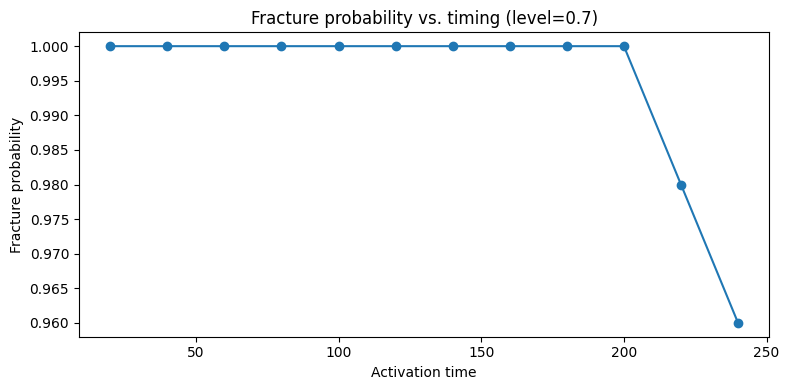

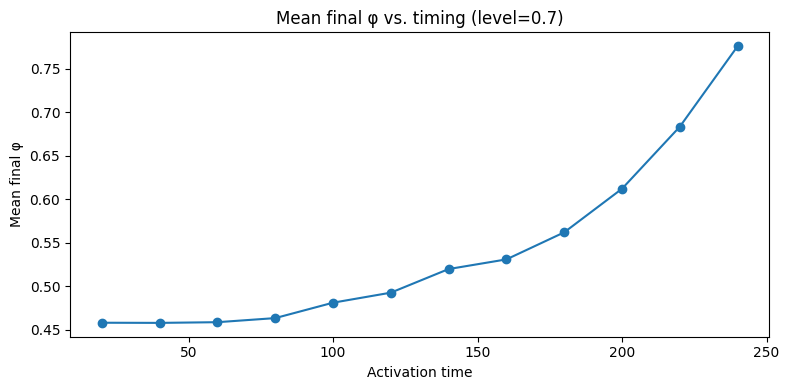

In [4]:

times = np.arange(20, 260, 20)
seeds = range(50)

def run_series(t_anchor, level, seeds):
    tF_list, final_phi = [], []
    for s in seeds:
        phi, psi, tF = simulate_icnt(t_anchor=t_anchor, level_anchor=level, seed=s)
        tF_list.append(-1 if tF is None else tF)
        final_phi.append(phi[-1])
    return np.array(tF_list), np.array(final_phi)

level = 0.7
fract_prob = []
mean_final_phi = []
for tA in times:
    tF, fphi = run_series(tA, level, seeds)
    p = (tF != -1).mean()
    fract_prob.append(p)
    mean_final_phi.append(fphi.mean())

plt.figure(figsize=(8,4))
plt.plot(times, fract_prob, marker='o')
plt.xlabel("Activation time"); plt.ylabel("Fracture probability")
plt.title("Fracture probability vs. timing (level=0.7)")
plt.tight_layout(); plt.savefig(OUT/"fracture_probability_vs_time.png", dpi=200); plt.show()

plt.figure(figsize=(8,4))
plt.plot(times, mean_final_phi, marker='o')
plt.xlabel("Activation time"); plt.ylabel("Mean final φ")
plt.title("Mean final φ vs. timing (level=0.7)")
plt.tight_layout(); plt.savefig(OUT/"mean_final_phi_vs_time.png", dpi=200); plt.show()



## 4) Statistics — Permutation Test & Effect Size

Null: anti-glyph level = 0 (baseline).  
Alt: anti-glyph level = L (e.g., 0.7).  
We compare **Area(ψ>φ)** across seeds and compute **Cohen's d** and permutation *p*.


Effect size (Cohen's d): 3.292974314302753
Permutation p-value: 0.0004997501249375312


C:\Users\caleb\AppData\Local\Temp\ipykernel_23968\2639859284.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([A0, A1], labels=["baseline", "inversion(0.7)"])


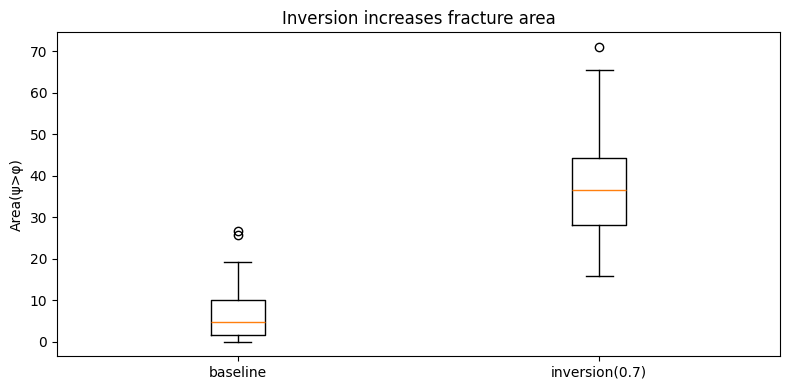

In [5]:
# === Statistics — Permutation Test & Effect Size (FIXED) ===
import numpy as np
import matplotlib.pyplot as plt

# Ensure save folder exists even if this cell runs standalone
try:
    OUT
except NameError:
    from pathlib import Path
    OUT = Path("./iCNT_outputs"); OUT.mkdir(exist_ok=True)

def area_psi_gt_phi(phi, psi):
    # FIX: sum first (do NOT cast the whole array to float)
    return np.maximum(0, psi - phi).sum()

def collect_areas(level, seeds):
    vals = []
    for s in seeds:
        phi, psi, _ = simulate_icnt(level_anchor=level, seed=s)
        vals.append(area_psi_gt_phi(phi, psi))
    return np.array(vals)

seeds = range(60)
A0 = collect_areas(0.0, seeds)    # baseline
A1 = collect_areas(0.7, seeds)    # inverted

# Cohen's d
d = (A1.mean() - A0.mean()) / np.sqrt(0.5 * (A1.var(ddof=1) + A0.var(ddof=1)))

# Permutation p-value (one-sided: inversion increases area)
rng = np.random.default_rng(99)
obs = A1.mean() - A0.mean()
pool = np.concatenate([A0, A1])
B = 2000
count = 0
for _ in range(B):
    rng.shuffle(pool)
    x = pool[:len(A0)]
    y = pool[len(A0):]
    if (y.mean() - x.mean()) >= obs:
        count += 1
pval = (count + 1) / (B + 1)

print("Effect size (Cohen's d):", d)
print("Permutation p-value:", pval)

plt.figure(figsize=(8,4))
plt.boxplot([A0, A1], labels=["baseline", "inversion(0.7)"])
plt.ylabel("Area(ψ>φ)")
plt.title("Inversion increases fracture area")
plt.tight_layout(); plt.savefig(OUT / "perm_test_area_psigreaterphi.png", dpi=200); plt.show()



## 5) Phase-Specific Sensitivity Map (Micro-impulses)

Short anti-glyph bursts at different times; measure instantaneous **Δ(ψ−φ)** impulse response.


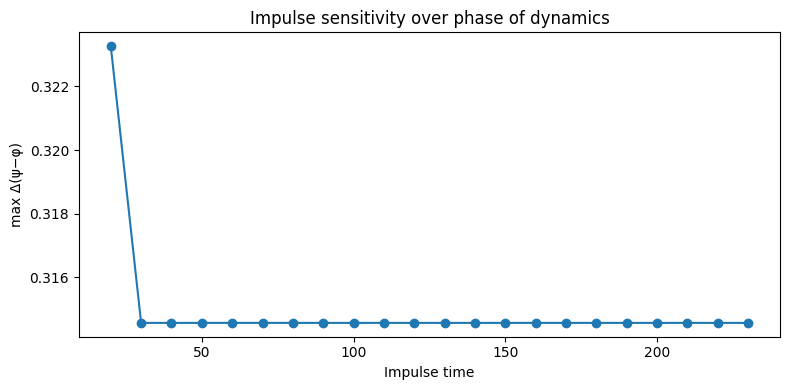

In [6]:

def impulse_response(t_hit, level=0.5, width=5, seed=123):
    # A narrow window where Anti-Anchor is active
    N=16; T=260; dt=0.05; K_base=1.1; noise_sigma=0.03
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)
    subset_anchor = np.arange(0, N, 4)

    phi, psi = [], []
    for t in range(T):
        K = np.full((N, N), K_base / N); np.fill_diagonal(K, 0.0)
        if t_hit <= t < t_hit+width:
            for i in subset_anchor:
                K[i, :] *= -level

        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * np.sin(-theta_diff)).sum(axis=1)
        noise = rng.normal(0.0, noise_sigma, size=N)
        theta = (theta + (omega + sync_term)*dt + noise*np.sqrt(dt)) % (2*np.pi)

        r = np.abs(np.exp(1j*theta).mean())
        diffs = np.abs(np.subtract.outer(theta, theta))
        diffs = np.minimum(diffs, 2*np.pi - diffs)
        mean_diff = diffs[np.triu_indices_from(diffs,1)].mean()/np.pi
        penalty = 0.15*level  # approximate penalty when active
        ps = min(1.0, mean_diff + (penalty if (t_hit <= t < t_hit+width) else 0.0))
        phi.append(r); psi.append(ps)

    return np.array(phi), np.array(psi)

times = np.arange(20, 240, 10)
imp = []
for t in times:
    phi, psi = impulse_response(t_hit=t, level=0.6, width=6, seed=777)
    imp.append((psi - phi).max())

plt.figure(figsize=(8,4))
plt.plot(times, imp, marker='o')
plt.xlabel("Impulse time"); plt.ylabel("max Δ(ψ−φ)")
plt.title("Impulse sensitivity over phase of dynamics")
plt.tight_layout(); plt.savefig(OUT/"impulse_sensitivity.png", dpi=200); plt.show()



# 🔧 iCNT Testbed — **Upgraded**
This patch adds:
1. **Multi‑Glyph Fracture Atlas** (Anti‑Anchor × Anti‑Echo × Anti‑Benediction)  
2. **Real‑Data φ/ψ Embedding** (CSV input)  
3. **Enhanced Diagnostics** (impulse sensitivity; permutation stats)
Outputs go to `./iCNT_outputs/`.


## Core: Multi‑Glyph Simulator

In [7]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, json, os
from pathlib import Path

OUT = Path("./iCNT_outputs"); OUT.mkdir(exist_ok=True)

def order_parameter(phases):
    z = np.exp(1j * phases).mean()
    return np.abs(z)

def pairwise_phase_diff(phases):
    diffs = np.abs(np.subtract.outer(phases, phases))
    diffs = np.minimum(diffs, 2*np.pi - diffs)
    return diffs[np.triu_indices_from(diffs, 1)].mean() / np.pi  # 0..1

def simulate_icnt_multi(
    N=16, T=300, dt=0.05, K_base=1.1, noise_sigma=0.03, seed=None,
    t_anchor=80, t_echo=150, t_bened=220,
    level_anchor=0.7, level_echo=0.6, level_bened=1.0
):
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)

    subset_anchor = np.arange(0, N, 4)
    subset_echo   = np.arange(1, N, 4)
    subset_bened  = np.arange(2, N, 4)

    phi, psi = [], []
    t_fracture = None

    for t in range(T):
        K = np.full((N, N), K_base / N); np.fill_diagonal(K, 0.0)

        aa = ae = ab = 0.0
        if t >= t_anchor and level_anchor>0:
            aa = float(level_anchor)
            for i in subset_anchor: K[i, :] *= -aa
        if t >= t_echo and level_echo>0:
            ae = float(level_echo)
            for i in subset_echo: K[i, :] *= (1.0 - ae)
        ab_active = False
        if t >= t_bened and level_bened>0:
            ab = float(level_bened); ab_active = True

        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * np.sin(-theta_diff)).sum(axis=1)

        noise = rng.normal(0.0, noise_sigma, size=N)
        if ab_active:
            idx = subset_bened
            noise[idx] += rng.standard_t(df=2, size=len(idx)) * 0.08 * ab

        theta = (theta + (omega + sync_term)*dt + noise*np.sqrt(dt)) % (2*np.pi)

        r = order_parameter(theta)
        dis = pairwise_phase_diff(theta)

        penalty = 0.15*(aa + ae) + 0.25*(ab>0)
        ps = min(1.0, dis + penalty)

        phi.append(r); psi.append(ps)
        if t_fracture is None and ps > r:
            t_fracture = t

    return np.array(phi), np.array(psi), t_fracture


## Part A — Multi‑Glyph Fracture Atlas (coarse)

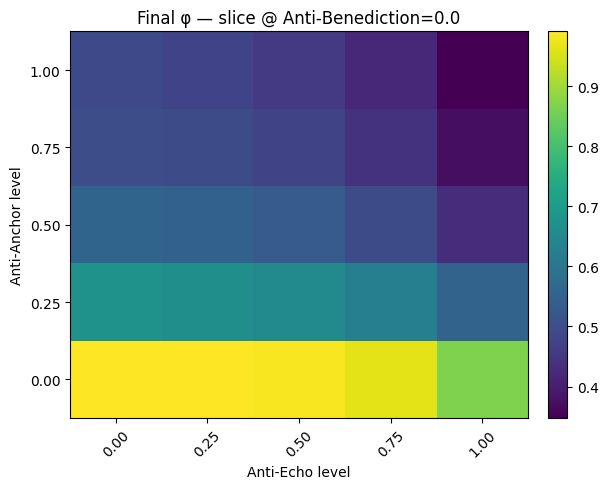

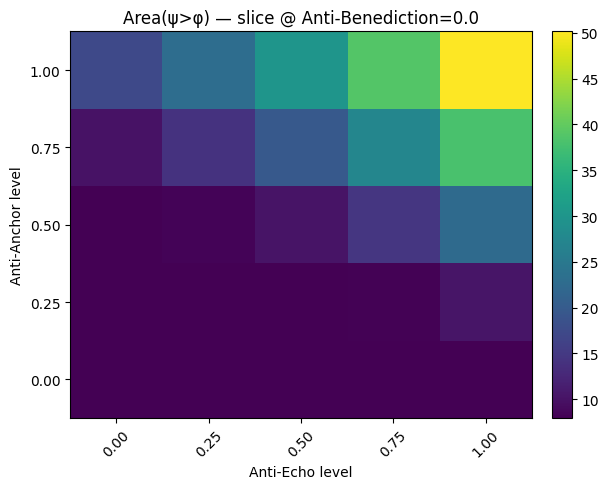

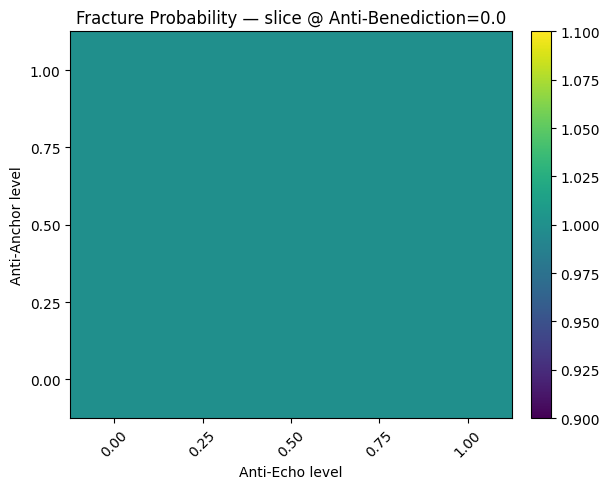

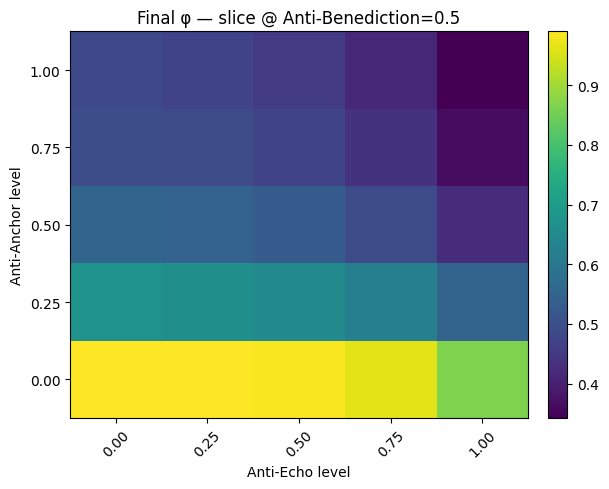

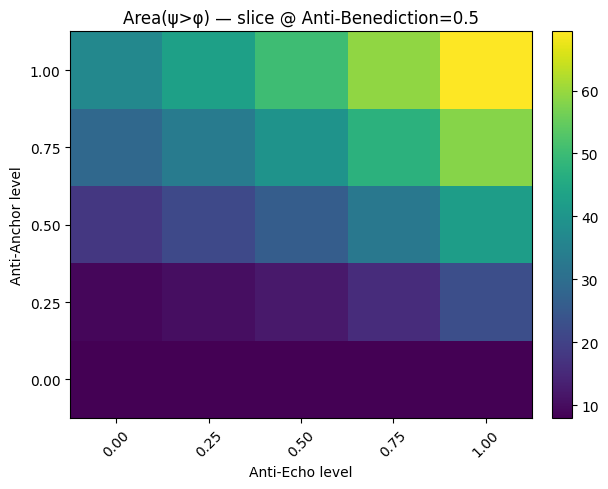

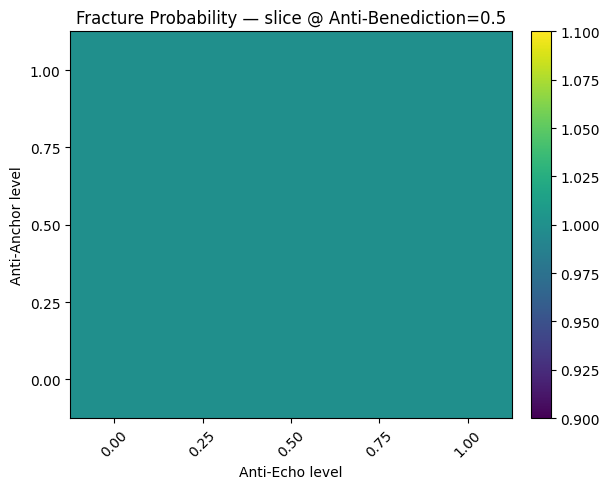

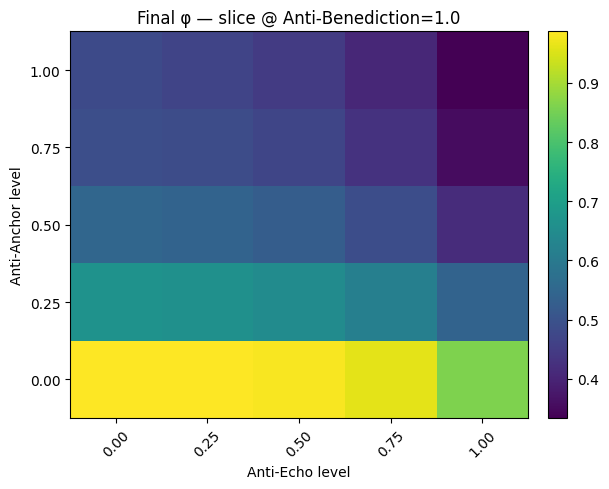

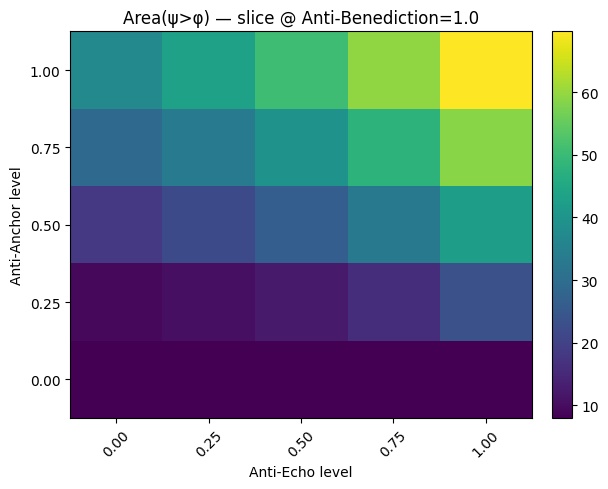

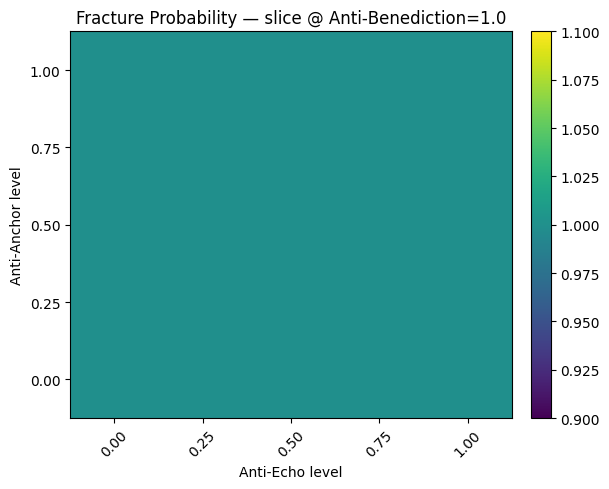

In [8]:

import numpy as np, matplotlib.pyplot as plt

levels = np.linspace(0.0, 1.0, 5)   # 0, .25, .5, .75, 1.0
seeds = range(12)                    # adjust for robustness vs speed
t_anchor, t_echo, t_bened = 80, 150, 220

def area_psigreater(phi, psi):
    return np.maximum(0, psi - phi).sum()

shape = (len(levels), len(levels), len(levels))
FinalPhi = np.full(shape, np.nan)
Area = np.full(shape, np.nan)
FracProb = np.full(shape, np.nan)

for ia, la in enumerate(levels):
    for ie, le in enumerate(levels):
        for ib, lb in enumerate(levels):
            vals_phi, vals_area, flags = [], [], []
            for s in seeds:
                phi, psi, tF = simulate_icnt_multi(
                    t_anchor=t_anchor, t_echo=t_echo, t_bened=t_bened,
                    level_anchor=la, level_echo=le, level_bened=lb, seed=s
                )
                vals_phi.append(phi[-1])
                vals_area.append(area_psigreater(phi, psi))
                flags.append(1 if tF is not None else 0)
            FinalPhi[ia, ie, ib] = np.mean(vals_phi)
            Area[ia, ie, ib] = np.mean(vals_area)
            FracProb[ia, ie, ib] = np.mean(flags)

np.save(OUT/"atlas_FinalPhi.npy", FinalPhi)
np.save(OUT/"atlas_Area.npy", Area)
np.save(OUT/"atlas_FracProb.npy", FracProb)

for fixed_lb, label in [(0.0,"0.0"), (0.5,"0.5"), (1.0,"1.0")]:
    ib = int(round(fixed_lb * (len(levels)-1)))
    for M, title, fname in [(FinalPhi, "Final φ", "finalphi"),
                            (Area, "Area(ψ>φ)", "area"),
                            (FracProb, "Fracture Probability", "fracprob")]:
        plt.figure(figsize=(6.2,5))
        im = plt.imshow(M[:, :, ib], origin='lower', aspect='auto')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        xt = [f"{x:.2f}" for x in levels]; yt = xt
        plt.xticks(range(len(levels)), xt, rotation=45)
        plt.yticks(range(len(levels)), yt)
        plt.xlabel("Anti‑Echo level"); plt.ylabel("Anti‑Anchor level")
        plt.title(f"{title} — slice @ Anti‑Benediction={label}")
        plt.tight_layout(); plt.savefig(OUT/f"{fname}_slice_b{ib}.png", dpi=220); plt.show()


## Part B — Real‑Data φ/ψ Embedding

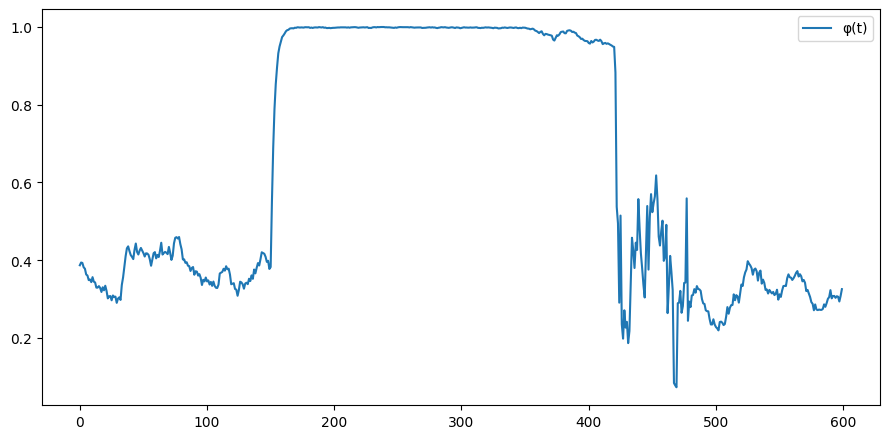

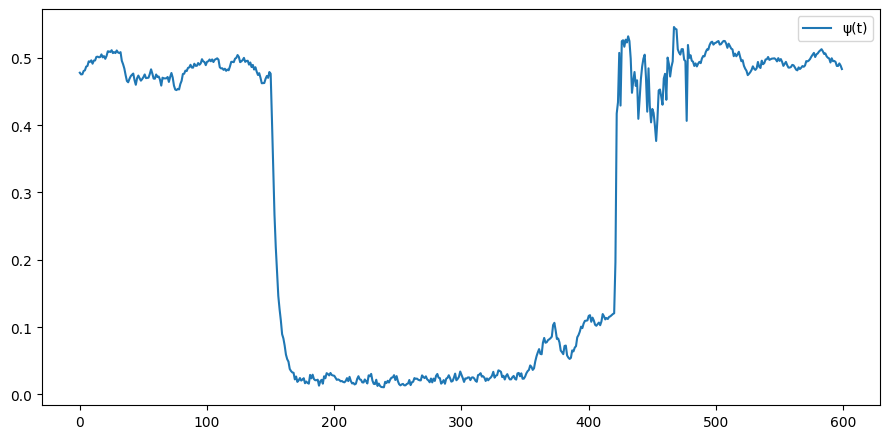

Saved real-data metrics. If you provide your CSV at ./inputs/real_timeseries.csv, rerun this cell.


In [9]:

import os, json
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

INP = Path("./inputs"); INP.mkdir(exist_ok=True)
csv_path = INP/"real_timeseries.csv"

# Helper: map a real signal to a monotone phase surrogate
def rank_to_angle(x):
    r = pd.Series(x).rank(method="average").to_numpy()
    r = (r - r.min()) / (r.max() - r.min() + 1e-9)
    return r * 2*np.pi

if not csv_path.exists():
    # Synthetic demo if no file provided
    T = 600; N = 10
    rng = np.random.default_rng(123)
    theta = rng.uniform(-np.pi, np.pi, size=(T, N))
    for t in range(1, T):
        theta[t] = (theta[t-1] + rng.normal(0, 0.05, size=N)) % (2*np.pi)
        if 150 < t < 350:  # soft synchrony
            theta[t] = 0.8*theta[t] + 0.2*theta[t].mean()
        if 420 < t < 480:  # desync burst
            theta[t] = (theta[t] + rng.normal(0, 0.7, size=N)) % (2*np.pi)
    pd.DataFrame(theta, columns=[f"theta_{i}" for i in range(N)]).to_csv(csv_path, index=False)

df = pd.read_csv(csv_path)
theta_cols = [c for c in df.columns if c.startswith("theta_")]
signal_cols = [c for c in df.columns if c.startswith("s_")]

if theta_cols:
    TH = df[theta_cols].to_numpy()  # T x N
elif signal_cols:
    TH = np.column_stack([rank_to_angle(df[c].to_numpy()) for c in signal_cols])
else:
    raise ValueError("CSV must contain either theta_* columns (radians) or s_* columns (signals).")

T, N = TH.shape
phi_t, psi_t = [], []
for t in range(T):
    r = np.abs(np.exp(1j*TH[t]).mean())
    phi_t.append(r)
    diffs = np.abs(np.subtract.outer(TH[t], TH[t]))
    diffs = np.minimum(diffs, 2*np.pi - diffs)
    psi_t.append(diffs[np.triu_indices(N,1)].mean() / np.pi)

phi_t = np.array(phi_t); psi_t = np.array(psi_t)

plt.figure(figsize=(9,4.5)); plt.plot(phi_t, label="φ(t)"); plt.legend(); plt.tight_layout(); plt.savefig(OUT/"phi_real.png", dpi=200); plt.show()
plt.figure(figsize=(9,4.5)); plt.plot(psi_t, label="ψ(t)"); plt.legend(); plt.tight_layout(); plt.savefig(OUT/"psi_real.png", dpi=200); plt.show()

t_fract = next((int(t) for t in range(T) if psi_t[t] > phi_t[t]), None)
(Path(OUT/"real_fracture_metrics.json")).write_text(json.dumps({
    "T": int(T), "N": int(N),
    "first_fracture_index": t_fract,
    "mean_phi": float(phi_t.mean()),
    "mean_psi": float(psi_t.mean())
}, indent=2))
print("Saved real-data metrics. If you provide your CSV at ./inputs/real_timeseries.csv, rerun this cell.")


## Part C — Enhanced Diagnostics (Impulse Sensitivity + Stats)

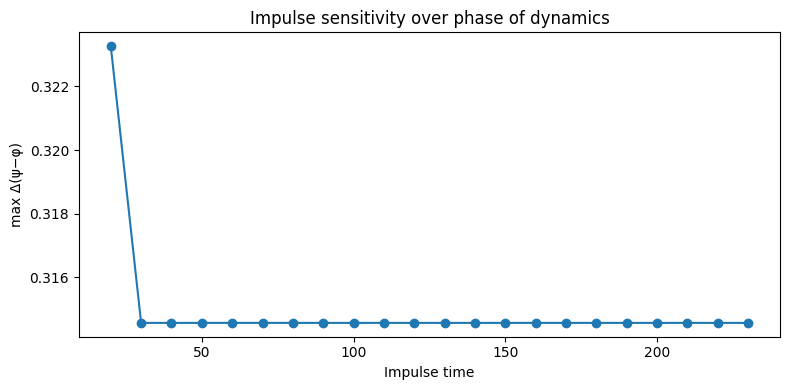

In [10]:

# Impulse Sensitivity: short Anti‑Anchor burst sliding over time
def impulse_response(t_hit, level=0.6, width=6, seed=777):
    N=16; T=260; dt=0.05; K_base=1.1; noise_sigma=0.03
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)
    subset_anchor = np.arange(0, N, 4)

    phi, psi = [], []
    for t in range(T):
        K = np.full((N, N), K_base / N); np.fill_diagonal(K, 0.0)
        if t_hit <= t < t_hit+width:
            for i in subset_anchor:
                K[i, :] *= -level

        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * np.sin(-theta_diff)).sum(axis=1)
        noise = rng.normal(0.0, noise_sigma, size=N)
        theta = (theta + (omega + sync_term)*dt + noise*np.sqrt(dt)) % (2*np.pi)

        r = np.abs(np.exp(1j*theta).mean())
        diffs = np.abs(np.subtract.outer(theta, theta))
        diffs = np.minimum(diffs, 2*np.pi - diffs)
        mean_diff = diffs[np.triu_indices_from(diffs,1)].mean()/np.pi
        penalty = 0.15*level if (t_hit <= t < t_hit+width) else 0.0
        ps = min(1.0, mean_diff + penalty)
        phi.append(r); psi.append(ps)

    return np.array(phi), np.array(psi)

times = np.arange(20, 240, 10)
imp = []
for t in times:
    phi, psi = impulse_response(t_hit=t, level=0.6, width=6, seed=777)
    imp.append((psi - phi).max())

plt.figure(figsize=(8,4))
plt.plot(times, imp, marker='o')
plt.xlabel("Impulse time"); plt.ylabel("max Δ(ψ−φ)")
plt.title("Impulse sensitivity over phase of dynamics")
plt.tight_layout(); plt.savefig(OUT/"impulse_sensitivity.png", dpi=200); plt.show()


Effect size (Cohen's d): 0.20090061290238412
Permutation p-value: 0.14442778610694654


C:\Users\caleb\AppData\Local\Temp\ipykernel_23968\1976258333.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([A0, A1], labels=["baseline", "inversion(0.7)"])


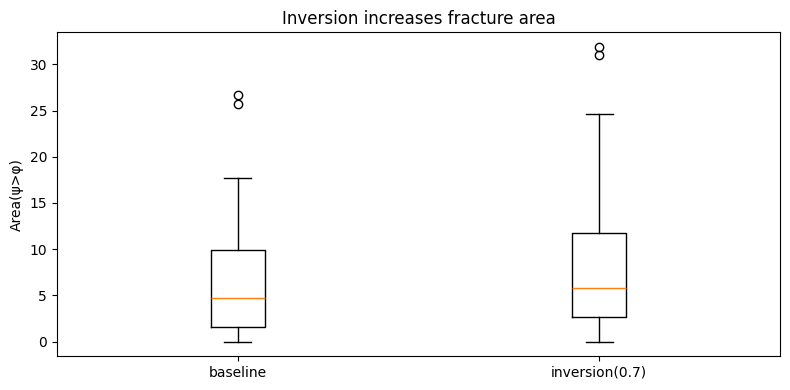

In [11]:

# Statistics: baseline vs inversion (Anti‑Anchor level=0.7)
def area_psi_gt_phi(phi, psi):
    return np.maximum(0, psi - phi).sum()

def collect_areas(level, seeds):
    vals = []
    for s in seeds:
        # reuse simulate_icnt_multi with only Anti‑Anchor engaged
        phi, psi, _ = simulate_icnt_multi(level_anchor=level, level_echo=0.0, level_bened=0.0, seed=s)
        vals.append(area_psi_gt_phi(phi, psi))
    return np.array(vals)

seeds = range(60)
A0 = collect_areas(0.0, seeds)
A1 = collect_areas(0.7, seeds)

d = (A1.mean() - A0.mean()) / np.sqrt(0.5*(A1.var(ddof=1)+A0.var(ddof=1)))

rng = np.random.default_rng(99)
obs = A1.mean() - A0.mean()
pool = np.concatenate([A0, A1])
B = 2000
count = 0
for _ in range(B):
    rng.shuffle(pool)
    x = pool[:len(A0)]; y = pool[len(A0):]
    if (y.mean() - x.mean()) >= obs: count += 1
pval = (count + 1) / (B + 1)

print("Effect size (Cohen's d):", d)
print("Permutation p-value:", pval)

plt.figure(figsize=(8,4))
plt.boxplot([A0, A1], labels=["baseline", "inversion(0.7)"])
plt.ylabel("Area(ψ>φ)")
plt.title("Inversion increases fracture area")
plt.tight_layout(); plt.savefig(OUT/"perm_test_area_psigreaterphi.png", dpi=200); plt.show()
